https://www.kaggle.com/learn/feature-engineering
user count feature

# start

In [1]:
PRFX='0325_1'
trntmstmp=1584412344
valtmstmp=1585239083
import datetime
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (trntmstmp, valtmstmp)])

grand_total=1.5e8
MIN_TM_TRN=1580947200
MIN_TM_TST=1581552000
print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') for o in (MIN_TM_TRN, MIN_TM_TST)])


CHNKSZ=int(1e6)
VLSZ=int(1e6)
n_chnks_vl=int(VLSZ/CHNKSZ)
print('n_chnks_vl', n_chnks_vl)
TRSZ=int(1e7)
n_chnks_tr=int(TRSZ/CHNKSZ)
print('n_chnks_tr', n_chnks_tr)

POST_RATE_WANTED=0.2

['2020-03-17 02:32:24', '2020-03-26 16:11:23']
['2020-02-06 00:00:00', '2020-02-13 00:00:00']
n_chnks_vl 1
n_chnks_tr 10


# setup

In [2]:
from pathlib import Path
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import pickle
from tqdm import tqdm
from collections import Counter
import category_encoders as ce
pd.set_option('display.max_rows', 500)

from functools import reduce
import datetime
import time
# tm_start=time.time()
# time.sleep(2)
# time.time()-tm_start

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

SEED=101
HOME='/data/git/recsys20'
p_in=f'{HOME}/input'
p_out=f'{HOME}/output/{PRFX}'
Path(p_out).mkdir(exist_ok=True, parents=True)

from sklearn.metrics import precision_recall_curve, auc, log_loss

def compute_prauc(pred, gt):
    prec, recall, thresh = precision_recall_curve(gt, pred)
    prauc = auc(recall, prec)
    return prauc

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def compute_rce(pred, gt):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

# https://towardsdatascience.com/how-to-calibrate-undersampled-model-scores-8f3319c1ea5b
# How to use the function?
# Let’s say your goal is to generate a model that shows the credit default probabilities and your original 
# training data has 50,000 rows with only 500 of them labeled as target class. When you sample your non-target 
# instances randomly and reduce the total row count to 10,000, while conserving 500 target rows, our calibration
# function becomes:
# calibration(model_results, 50000, 500, 10000, 500)
# Here model_results is your model probability output array. After you train your model and put the results in it, your function is ready to use. 

def calibration(data, train_pop, target_pop, sampled_train_pop, sampled_target_pop):
    calibrated_data = \
    ((data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)) /
    ((
        (1 - data) * (1 - target_pop / train_pop) / (1 - sampled_target_pop / sampled_train_pop)
     ) +
     (
        data * (target_pop / train_pop) / (sampled_target_pop / sampled_train_pop)
     )))

    return calibrated_data

cols=[
'toks',
'hshtgs',
'twtid',
'media',
'links',
'domns',
'twttyp',
'lang',
'tm',

'u1id',
'u1_fllwer_cnt',
'u1_fllwng_cnt',
'u1_vrfed',
'u1_create_tm',

'u2id',
'u2_fllwer_cnt',
'u2_fllwng_cnt',
'u2_vrfed',
'u2_create_tm',

'u1_fllw_u2',
'reply_tm',
'retwt_tm',
'retwt_cmmnt_tm',
'like_tm',
]
cols_cat = ['twttyp','lang']
cols_val = cols[:-4]
cols_tgt_tmstmp=[
    'retwt_tm',
    'reply_tm',
    'like_tm',
    'retwt_cmmnt_tm',
]
cols_tgt=[o.split('_tm')[0] for o in cols_tgt_tmstmp]
tgts             = ['Retweet','Reply','Like','RTwCmnt',]
assert cols_tgt == ['retwt',  'reply','like','retwt_cmmnt',]
ntgts=len(tgts)


tgt2col=dict(zip(tgts,cols_tgt))
tgt2col

{'Retweet': 'retwt',
 'Reply': 'reply',
 'Like': 'like',
 'RTwCmnt': 'retwt_cmmnt'}

# prepare data

## prep func

In [3]:
def prp_df(df, istrn=True):
    tm_min = MIN_TM_TRN if istrn else MIN_TM_TST
    df['len_toks'] = df.toks.apply(len)
    for media in ['Photo', 'Video', 'GIF']:
        df[f'has_media_{media}'] = df.media.fillna('').apply(lambda x: media in x)
    for col in ['hshtgs', 'links', 'domns',]:
        df[f'num_{col}'] = df[col].fillna('').apply(lambda x: len(x.split('\t')) if len(x) else 0)

    df['twt_age'] = df.tm - tm_min
    df['u1_age']  = df.tm - df.u1_create_tm
    df['u2_age']  = df.tm - df.u2_create_tm

    tm_dt=pd.to_datetime(df.tm, unit='s')
    df['tm_dayofweek']=tm_dt.dt.dayofweek
    df['tm_hour']=tm_dt.dt.hour

    df['tmdlta_u2u1']  = df.u2_create_tm - df.u1_create_tm

    df['u1_fllwer_cnt_by_age'] = df.u1_fllwer_cnt / df.u1_age
    df['u1_fllwng_cnt_by_age'] = df.u2_fllwng_cnt / df.u2_age

    for col in cols_cat:
        df[col]=df[col].astype('category')

    df['u1u2']=df.u1id+'_'+df.u2id
    ce_features = ['twttyp', 'lang', 'u1id', 'u2id', 'u1u2', 'twtid']
    cnt_encd = ce.CountEncoder()
    cnt_encded = cnt_encd.fit_transform(df[ce_features])
    cnt_encded = cnt_encded.astype(int)
    cnt_encded.columns = [f'{col}_cnt' for col in ce_features]

    df = pd.concat([df,cnt_encded],1)
    if istrn: 
        df[cols_tgt]=df[cols_tgt_tmstmp].notna().astype('int8')
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns',  
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u1u2', 'u2id', 'twtid', ]+cols_tgt_tmstmp, )
    else:
        df.drop(inplace=True, columns=['toks', 'hshtgs', 'media', 'links', 'domns', 
                                       'tm', 'u1_create_tm','u2_create_tm', 'u1id', 'u1u2'])   
    return df

In [4]:
grand_total, grand_total/CHNKSZ, grand_total/TRSZ

(150000000.0, 150.0, 15.0)

## valid data

In [5]:
chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                    header=None,names=cols, 
                    chunksize=CHNKSZ)
# first chunk as validate data
for ichnk,df in enumerate(chnks_trn):
    if ichnk==n_chnks_vl: break
    print(dtnow(), 'chunk', ichnk)
#     print([datetime.datetime.fromtimestamp(o).strftime('%Y-%m-%d %H:%M:%S') 
#            for o in (df.tm.min(), df.tm.max())])
    dfvalid = prp_df(df)
print('dfvalid.shape:',dfvalid.shape)

cols_feat=[o for o in dfvalid.columns if o not in cols_tgt]

display(dfvalid[cols_feat].dtypes)

2020-03-26 14:32:22 chunk 0


/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


dfvalid.shape: (1000000, 34)


twttyp                  category
lang                    category
u1_fllwer_cnt              int64
u1_fllwng_cnt              int64
u1_vrfed                    bool
u2_fllwer_cnt              int64
u2_fllwng_cnt              int64
u2_vrfed                    bool
u1_fllw_u2                  bool
len_toks                   int64
has_media_Photo             bool
has_media_Video             bool
has_media_GIF               bool
num_hshtgs                 int64
num_links                  int64
num_domns                  int64
twt_age                    int64
u1_age                     int64
u2_age                     int64
tm_dayofweek               int64
tm_hour                    int64
tmdlta_u2u1                int64
u1_fllwer_cnt_by_age     float64
u1_fllwng_cnt_by_age     float64
twttyp_cnt                 int64
lang_cnt                   int64
u1id_cnt                   int64
u2id_cnt                   int64
u1u2_cnt                   int64
twtid_cnt                  int64
dtype: obj

## trnval data func

In [6]:
def getdftrvl(tgt):
    print(tgt)
    tgtcol=tgt2col[tgt]
    chnks_trn = pd.read_csv(f'{p_in}/trn_{trntmstmp}.tsv',sep='\x01',
                        header=None,names=cols, 
                            chunksize=CHNKSZ)
    len_df_wanted = TRSZ
    # retwt          0.113031
    # reply          0.027488
    # like           0.439499
    # retwt_cmmnt    0.007742
    pos_rate_wanted = POST_RATE_WANTED
    n_pos_wanted = int(len_df_wanted*pos_rate_wanted)
    print('n_pos_wanted', n_pos_wanted)
    np.random.seed(SEED)
    lst_df = []
    n_pos_ttl = 0
    for ichnk,df in enumerate(chnks_trn):
        #skip first chunks (it was validate data)
        if ichnk<n_chnks_vl: continue
        df = prp_df(df)
        n_pos_ttl+= df[tgtcol].sum()
        lst_df.append(df)
        if (ichnk>=n_chnks_vl+n_chnks_tr) and (n_pos_ttl>=n_pos_wanted): break
        print(dtnow(), 'chunk', ichnk, 'n_pos_ttl', n_pos_ttl)

    df = pd.concat(lst_df)
    df.reset_index(drop=True,inplace=True)


    # https://stackoverflow.com/questions/28556942/pandas-remove-rows-at-random-without-shuffling-dataset
    idx_neg=np.where(df[tgtcol]==0)[0]
    n_neg = len(idx_neg)
    n_pos = len(df)-len(idx_neg)
    n_neg2keep = len_df_wanted-n_pos
    n_neg2rmv = n_neg-n_neg2keep
    if n_neg2rmv>0:
        idx_neg2rmv = np.random.choice(idx_neg, n_neg2rmv, replace=False)
        dftrvl = df.drop(idx_neg2rmv)
    else:
        dftrvl = df
    dftrvl = dftrvl.sample(len_df_wanted, replace=False)
    for col in cols_cat:
        dftrvl[col]=dftrvl[col].astype('category')
    
#     display(dftrvl.dtypes)
    print('dftrvl.shape:',dftrvl.shape,'dftrvl[tgtcol].mean():',dftrvl[tgtcol].mean())
    
    pops={
        'train_pop':len(df),
        'target_pop':n_pos,
        'sampled_train_pop':len_df_wanted,
        'sampled_target_pop':n_pos,
    }
    print(pops)
    return dftrvl, pops

# model

In [7]:
def train(params,dtr,dvl):
    print(params)
    evals_result = {}
    evallist = [(dtr, 'train'), (dvl, 'eval')]
    bst = lgb.train(params=params, 
                    train_set=dtr, 
                    num_boost_round=100000,
                    valid_sets=[dtr, dvl],
                    verbose_eval=1000,
                    early_stopping_rounds=100,
                    evals_result=evals_result,
                   )
    return bst,evals_result

def valid(bst,dftr,dfvl):
    prdtr = bst.predict(dftr[cols_feat],num_iteration=bst.best_iteration)
    prdvl = bst.predict(dfvl[cols_feat],num_iteration=bst.best_iteration)
    return prdtr,prdvl

def do_tgt(tgt):
    params=tgt2params[tgt]
    tgtcol=tgt2col[tgt]
    dftrvl, pops=getdftrvl(tgt)
    split=int(len(dftrvl)*0.85)
    dftr,dfvl=dftrvl[:split],dftrvl[split:]
    dtr = lgb.Dataset(dftr[cols_feat], label=dftr[tgtcol])
    dvl = lgb.Dataset(dfvl[cols_feat], label=dfvl[tgtcol])
    bst,evlres=train(params,dtr,dvl)
    prdtr,prdvl=valid(bst,dftr,dfvl)
    
    tgt2bst[tgt]=bst
    tgt2evlres[tgt]=evlres
    tgt2ytr[tgt]=dftr[tgtcol]
    tgt2yvl[tgt]=dfvl[tgtcol]
    tgt2pops[tgt]=pops
    tgt2prdtr[tgt]=prdtr
    tgt2prdvl[tgt]=prdvl


In [8]:
params_shared = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": 0,
    "boosting_type": "gbdt",
}
tgt2params = {k:params_shared for k in tgts}

tgt2bst={}
tgt2evlres={}
tgt2tuning_history={}
tgt2ytr={}
tgt2yvl={}
tgt2prdtr={}
tgt2prdvl={}
tgt2pops={}
for tgt in tgts:
    print(dtnow(), tgt, '*'*80)
    tmstart=time.time()
    do_tgt(tgt)
    print('ran for',int((time.time()-tmstart)/60),'mins')
    
pickle.dump(tgt2bst, open(f"{p_out}/tgt2bst.p", "wb"))

2020-03-26 14:32:45 Retweet ********************************************************************************
Retweet
n_pos_wanted 2000000
2020-03-26 14:33:12 chunk 1 n_pos_ttl 112823
2020-03-26 14:33:32 chunk 2 n_pos_ttl 226081
2020-03-26 14:33:52 chunk 3 n_pos_ttl 338645
2020-03-26 14:34:13 chunk 4 n_pos_ttl 452019
2020-03-26 14:34:33 chunk 5 n_pos_ttl 565298
2020-03-26 14:34:53 chunk 6 n_pos_ttl 678591
2020-03-26 14:35:12 chunk 7 n_pos_ttl 791588
2020-03-26 14:35:32 chunk 8 n_pos_ttl 904490
2020-03-26 14:35:53 chunk 9 n_pos_ttl 1017793
2020-03-26 14:36:13 chunk 10 n_pos_ttl 1131194
2020-03-26 14:36:33 chunk 11 n_pos_ttl 1243970
2020-03-26 14:36:53 chunk 12 n_pos_ttl 1356713
2020-03-26 14:37:13 chunk 13 n_pos_ttl 1470005
2020-03-26 14:37:33 chunk 14 n_pos_ttl 1582955
2020-03-26 14:37:53 chunk 15 n_pos_ttl 1695443
2020-03-26 14:38:13 chunk 16 n_pos_ttl 1809038
2020-03-26 14:38:33 chunk 17 n_pos_ttl 1921414
dftrvl.shape: (10000000, 34) dftrvl[tgtcol].mean(): 0.2033516
{'train_pop': 1800

[5000]	training's binary_logloss: 0.535521	valid_1's binary_logloss: 0.546663
[6000]	training's binary_logloss: 0.532333	valid_1's binary_logloss: 0.545719
[7000]	training's binary_logloss: 0.529375	valid_1's binary_logloss: 0.545041
[8000]	training's binary_logloss: 0.526382	valid_1's binary_logloss: 0.544195
[9000]	training's binary_logloss: 0.523655	valid_1's binary_logloss: 0.54363
[10000]	training's binary_logloss: 0.520954	valid_1's binary_logloss: 0.543012
[11000]	training's binary_logloss: 0.518419	valid_1's binary_logloss: 0.542527
[12000]	training's binary_logloss: 0.516147	valid_1's binary_logloss: 0.542317
[13000]	training's binary_logloss: 0.513807	valid_1's binary_logloss: 0.542026
Early stopping, best iteration is:
[13863]	training's binary_logloss: 0.511857	valid_1's binary_logloss: 0.541757
ran for 87 mins
2020-03-26 19:22:16 RTwCmnt ********************************************************************************
RTwCmnt
n_pos_wanted 2000000
2020-03-26 19:22:43 chunk 1

[2000]	training's binary_logloss: 0.309406	valid_1's binary_logloss: 0.315583
[3000]	training's binary_logloss: 0.305967	valid_1's binary_logloss: 0.315055
[4000]	training's binary_logloss: 0.302951	valid_1's binary_logloss: 0.314764
[5000]	training's binary_logloss: 0.300076	valid_1's binary_logloss: 0.314521
[6000]	training's binary_logloss: 0.297384	valid_1's binary_logloss: 0.314411
[7000]	training's binary_logloss: 0.294814	valid_1's binary_logloss: 0.314321
[8000]	training's binary_logloss: 0.292242	valid_1's binary_logloss: 0.314197
Early stopping, best iteration is:
[8255]	training's binary_logloss: 0.291607	valid_1's binary_logloss: 0.31417
ran for 100 mins


# analyze

## tr vl

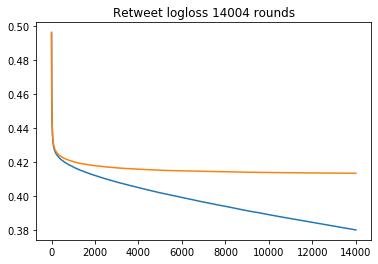

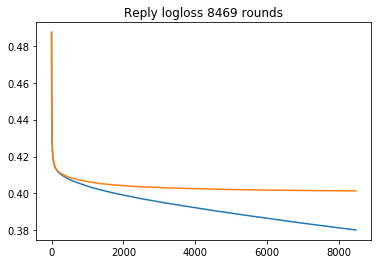

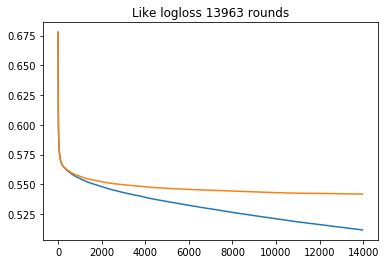

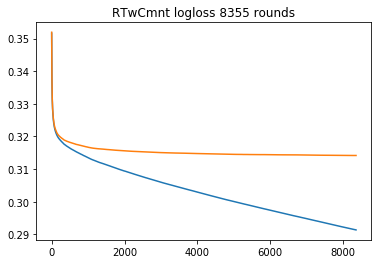

In [9]:
for tgt in tgt2evlres:
    evlres=tgt2evlres[tgt]
    plt.plot(evlres['training']['binary_logloss'])
    plt.plot(evlres['valid_1']['binary_logloss'])
    plt.title(f"{tgt} logloss {len(evlres['valid_1']['binary_logloss'])} rounds")
    plt.show()

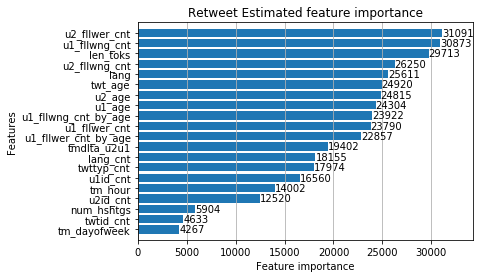

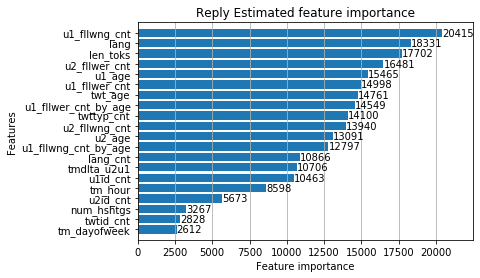

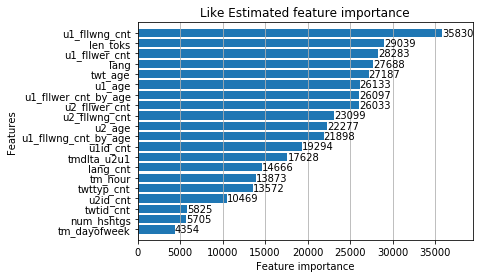

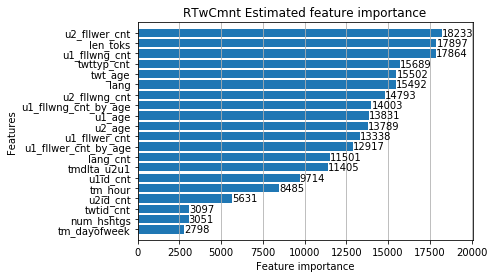

In [10]:
def show_feat_importance(tgt):
    bst=tgt2bst[tgt]
    ax = lgb.plot_importance(bst, height=0.8, max_num_features=20)
    ax.grid(False, axis="y")
    ax.set_title(f'{tgt} Estimated feature importance')
    plt.show()
#     feat2importance=bst.get_fscore()
#     print(tgt)
#     display(pd.DataFrame([feat2importance.keys(), 
#                           feat2importance.values()]).T.sort_values(1, ascending=False))

for tgt in tgt2bst:
    show_feat_importance(tgt)

In [11]:
tgt2auc_tr={}
tgt2rce_tr={}
tgt2auc_vl={}
tgt2rce_vl={}
for tgt in tgt2bst:
    print(tgt)
    prdtr_i, prdvl_i = tgt2prdtr[tgt], tgt2prdvl[tgt]
    ytr_i, yvl_i = tgt2ytr[tgt], tgt2yvl[tgt]
    scr_auc_tr=compute_prauc(prdtr_i, ytr_i)
    scr_rce_tr=compute_rce(prdtr_i, ytr_i)
    scr_auc_vl=compute_prauc(prdvl_i, yvl_i)
    scr_rce_vl=compute_rce(prdvl_i, yvl_i)

    tgt2auc_tr[tgt]=scr_auc_tr
    tgt2rce_tr[tgt]=scr_rce_tr
    tgt2auc_vl[tgt]=scr_auc_vl
    tgt2rce_vl[tgt]=scr_rce_vl
    
    print('tr prauc:', f'{scr_auc_tr:.4f}','tr rce:', f'{scr_rce_tr:.4f}', )
    print('vl prauc:', f'{scr_auc_vl:.4f}','vl rce:', f'{scr_rce_vl:.4f}', )

Retweet
tr prauc: 0.6038 tr rce: 24.6546
vl prauc: 0.5234 vl rce: 18.1942
Reply
tr prauc: 0.5649 tr rce: 24.0725
vl prauc: 0.5081 vl rce: 19.8738
Like
tr prauc: 0.8210 tr rce: 26.0958
vl prauc: 0.7875 vl rce: 21.7769
RTwCmnt
tr prauc: 0.4003 tr rce: 18.0703
vl prauc: 0.2988 vl rce: 11.7994


In [12]:
lsttr=[]
lstvl=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscr = pd.merge(dfscrtr, dfscrvl, on='metric', suffixes=('tr','vl'))
dfscr.T

,0,1,2,3,4,5,6,7
metric,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
scrtr,0.603822,24.6546,0.564866,24.0725,0.82096,26.0958,0.400308,18.0703
scrvl,0.523379,18.1942,0.508067,19.8738,0.787539,21.7769,0.298791,11.7994


## valid

In [13]:
# tgt=tgts[1]
# tgtcol=tgt2col[tgt]
# bst=tgt2bst[tgt]

# dvalid=xgb.DMatrix(dfvalid[cols_feat], label=dfvalid[tgtcol], feature_names=cols_feat)

# prdvalid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit)

# pops=tgt2pops[tgt]

# prdvalid[:10]
# # array([0.11734424, 0.09971393, 0.05619054, 0.03059793, 0.07979691,
# #        0.01358252, 0.05293725, 0.27954698, 0.05738379, 0.01741553],
# #       dtype=float32)


# pops
# # {'train_pop': 4000000,
# #  'target_pop': 109752,
# #  'sampled_train_pop': 1000000,
# #  'sampled_target_pop': 109752}

# prdvalid_calib = calibration(prdvalid, **pops)

# prdvalid_calib[:10]
# # array([0.02952491, 0.02471944, 0.01344113, 0.00717127, 0.01945818,
# #        0.00314114, 0.0126298 , 0.08155248, 0.01373977, 0.00403964],
# #       dtype=float32)

In [14]:
tgt2pops

{'Retweet': {'train_pop': 18000000,
  'target_pop': 2033516,
  'sampled_train_pop': 10000000,
  'sampled_target_pop': 2033516},
 'Reply': {'train_pop': 73000000,
  'target_pop': 2004500,
  'sampled_train_pop': 10000000,
  'sampled_target_pop': 2004500},
 'Like': {'train_pop': 11000000,
  'target_pop': 4833535,
  'sampled_train_pop': 10000000,
  'sampled_target_pop': 4833535},
 'RTwCmnt': {'train_pop': 147075238,
  'target_pop': 1145700,
  'sampled_train_pop': 10000000,
  'sampled_target_pop': 1145700}}

In [15]:
def do_post_valid(tgt):
    tgtcol=tgt2col[tgt]
    bst=tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdvalid = bst.predict(dfvalid[cols_feat],num_iteration=bst.best_iteration)
    prdvalid_calib = calibration(prdvalid, **pops)
    return prdvalid,prdvalid_calib

In [16]:
tgt2yvalid={tgt:dfvalid[tgt2col[tgt]] for tgt in tgts}
tgt2prdvalid={}
tgt2prdvalid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    tgt2prdvalid[tgt],tgt2prdvalid_calib[tgt]=do_post_valid(tgt)


2020-03-26 21:03:37 Retweet
2020-03-26 21:04:55 Reply
2020-03-26 21:05:19 Like
2020-03-26 21:06:33 RTwCmnt


In [17]:
tgt2auc_valid={}
tgt2rce_valid={}
tgt2auc_valid_calib={}
tgt2rce_valid_calib={}
for tgt in tgts:
    print(dtnow(), tgt)
    prdvalid, prdvalid_calib = tgt2prdvalid[tgt], tgt2prdvalid_calib[tgt]
    yvalid = tgt2yvalid[tgt]
    scr_auc_valid=compute_prauc(prdvalid, yvalid)
    scr_rce_valid=compute_rce(prdvalid, yvalid)
    scr_auc_valid_calib=compute_prauc(prdvalid_calib, yvalid)
    scr_rce_valid_calib=compute_rce(prdvalid_calib, yvalid)

    tgt2auc_valid[tgt]=scr_auc_valid
    tgt2rce_valid[tgt]=scr_rce_valid
    tgt2auc_valid_calib[tgt]=scr_auc_valid_calib
    tgt2rce_valid_calib[tgt]=scr_rce_valid_calib

2020-03-26 21:06:55 Retweet
2020-03-26 21:06:57 Reply
2020-03-26 21:06:59 Like
2020-03-26 21:07:01 RTwCmnt


In [18]:
for tgt in tgts:
    print(tgt)
    print('tr          prauc:', f'{tgt2auc_tr[tgt]:.4f}','tr rce:', f'{tgt2rce_tr[tgt]:.4f}', )
    print('vl          prauc:', f'{tgt2auc_vl[tgt]:.4f}','tr rce:', f'{tgt2rce_vl[tgt]:.4f}', )
    print('valid       prauc:', f'{tgt2auc_valid[tgt]:.4f}','tr rce:', f'{tgt2rce_valid[tgt]:.4f}', )
    print('valid_calib prauc:', f'{tgt2auc_valid_calib[tgt]:.4f}','tr rce:', f'{tgt2rce_valid_calib[tgt]:.4f}', )
    

Retweet
tr          prauc: 0.6038 tr rce: 24.6546
vl          prauc: 0.5234 tr rce: 18.1942
valid       prauc: 0.3726 tr rce: 9.7456
valid_calib prauc: 0.3726 tr rce: 16.3273
Reply
tr          prauc: 0.5649 tr rce: 24.0725
vl          prauc: 0.5081 tr rce: 19.8738
valid       prauc: 0.1245 tr rce: -75.8940
valid_calib prauc: 0.1245 tr rce: 14.0327
Like
tr          prauc: 0.8210 tr rce: 26.0958
vl          prauc: 0.7875 tr rce: 21.7769
valid       prauc: 0.7540 tr rce: 20.7993
valid_calib prauc: 0.7540 tr rce: 21.2281
RTwCmnt
tr          prauc: 0.4003 tr rce: 18.0703
vl          prauc: 0.2988 tr rce: 11.7994
valid       prauc: 0.0317 tr rce: -182.5126
valid_calib prauc: 0.0317 tr rce: 7.3887


In [19]:
lsttr=[]
lstvl=[]
lstvalid=[]
lstvalid_calib=[]
for tgt in ['Retweet','Reply','Like','RTwCmnt',]:
    if tgt not in tgt2bst: continue
    lsttr+=[(f'PRAUC {tgt}',tgt2auc_tr[tgt]),
          (f'RCE {tgt}',tgt2rce_tr[tgt])]
    lstvl+=[(f'PRAUC {tgt}',tgt2auc_vl[tgt]),
          (f'RCE {tgt}',tgt2rce_vl[tgt])]
    lstvalid+=[(f'PRAUC {tgt}',tgt2auc_valid[tgt]),
          (f'RCE {tgt}',tgt2rce_valid[tgt])]
    lstvalid_calib+=[(f'PRAUC {tgt}',tgt2auc_valid_calib[tgt]),
          (f'RCE {tgt}',tgt2rce_valid_calib[tgt])]

dfscrtr=pd.DataFrame(lsttr)
dfscrtr.columns=['metric','scr']
dfscrvl=pd.DataFrame(lstvl)
dfscrvl.columns=['metric','scr']
dfscrvalid=pd.DataFrame(lstvalid)
dfscrvalid.columns=['metric','scr']
dfscrvalid_calib=pd.DataFrame(lstvalid_calib)
dfscrvalid_calib.columns=['metric','scr']

dfscr = reduce(lambda df1,df2: pd.merge(df1,df2,on='metric'), 
            [dfscrtr,dfscrvl,dfscrvalid,dfscrvalid_calib])

dfscr.columns=['scr','tr','vl','valid','valid_calib']
dfscr.T

,0,1,2,3,4,5,6,7
scr,PRAUC Retweet,RCE Retweet,PRAUC Reply,RCE Reply,PRAUC Like,RCE Like,PRAUC RTwCmnt,RCE RTwCmnt
tr,0.603822,24.6546,0.564866,24.0725,0.82096,26.0958,0.400308,18.0703
vl,0.523379,18.1942,0.508067,19.8738,0.787539,21.7769,0.298791,11.7994
valid,0.372556,9.74556,0.124494,-75.894,0.754018,20.7993,0.0316503,-182.513
valid_calib,0.372556,16.3273,0.124494,14.0327,0.754018,21.2281,0.0316503,7.38875


# infer

In [20]:
%%time
dftst=pd.read_csv(
    f'{p_in}/val_{valtmstmp}.tsv',
#     f'{p_in}/val_259A6F6DFD672CB1F883CBEC01B99F2D_1584405047.tsv',
    sep='\x01', header=None, names=cols_val,)


CPU times: user 1min 32s, sys: 11 s, total: 1min 43s
Wall time: 1min 43s


In [21]:
%%time
dftst = prp_df(dftst, istrn=False)

/data/anaconda3/envs/rcss20/lib/python3.7/site-packages/category_encoders/count.py:255: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  X.loc[:, self.cols] = X.fillna(value=pd.np.nan)


CPU times: user 3min 22s, sys: 29.2 s, total: 3min 51s
Wall time: 3min 51s


In [22]:
%%time
tgt2prdtst={}
for tgt in tgts:
    print(dtnow(), tgt)
    bst = tgt2bst[tgt]
    pops=tgt2pops[tgt]
    prdtst = bst.predict(dftst[cols_feat], num_iteration=bst.best_iteration)
    prdtst_calib = calibration(prdtst, **pops)
    tgt2prdtst[tgt] = prdtst_calib

2020-03-26 21:12:38 Retweet
2020-03-26 21:30:54 Reply
2020-03-26 21:36:49 Like
2020-03-26 21:54:44 RTwCmnt
CPU times: user 23h 4min 58s, sys: 12min 35s, total: 23h 17min 34s
Wall time: 47min 53s


In [23]:
dfsub_ids = dftst[['twtid','u2id',]]

tgt2dfsub = {}
for tgt,prdtst in tgt2prdtst.items():
    dfsub = dfsub_ids.copy()
    dfsub['scr'] = prdtst
    tgt2dfsub[tgt]=dfsub

In [24]:
%%time
for i,tgt in enumerate(['Retweet','Reply','RTwCmnt','Like',]):
    dfsub = tgt2dfsub[tgt]
    print(dtnow(), tgt)
    dfsub.to_csv(f'{p_out}/{i}_{tgt}__{valtmstmp}__{PRFX}.csv',index=False,header=False)

2020-03-26 22:00:37 Retweet
2020-03-26 22:01:44 Reply
2020-03-26 22:02:50 RTwCmnt
2020-03-26 22:03:56 Like
CPU times: user 4min 10s, sys: 11.4 s, total: 4min 22s
Wall time: 4min 22s
